In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

In [4]:
transformation = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [5]:
train_data = datasets.ImageFolder(r"S:\Pneumonia classification project\Pneumonia classification project\chest_xray\train", transform=transformation)
test_data = datasets.ImageFolder(r"S:\Pneumonia classification project\Pneumonia classification project\chest_xray\test", transform=transformation)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

train_data.classes

['NORMAL', 'PNEUMONIA']

In [6]:
train_labels = train_data.targets
test_labels = test_data.targets
lbl_train = {"Normal": train_labels.count(0), "Pneumonia": train_labels.count(1)}
lbl_test = {"Normal": test_labels.count(0), "Pneumonia": test_labels.count(1)}

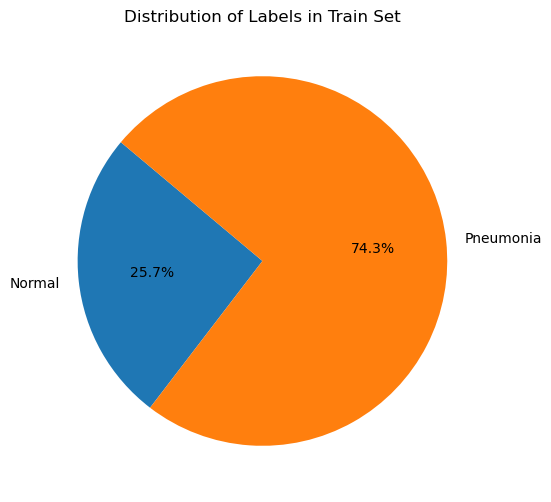

In [7]:
plt.figure(figsize=(6, 6))
plt.pie(lbl_train.values(), labels=lbl_train.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels in Train Set')
plt.show()

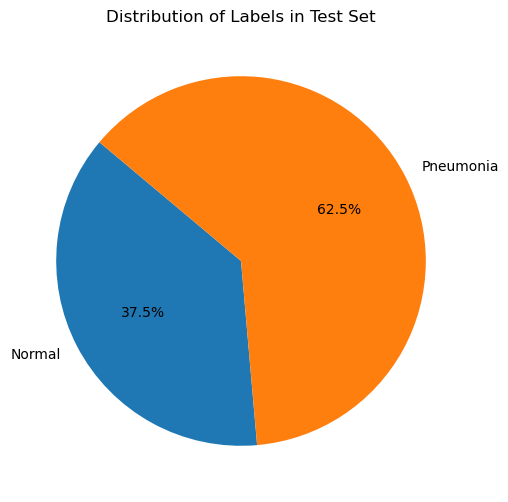

In [8]:
plt.figure(figsize=(6, 6))
plt.pie(lbl_test.values(), labels=lbl_test.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels in Test Set')
plt.show()

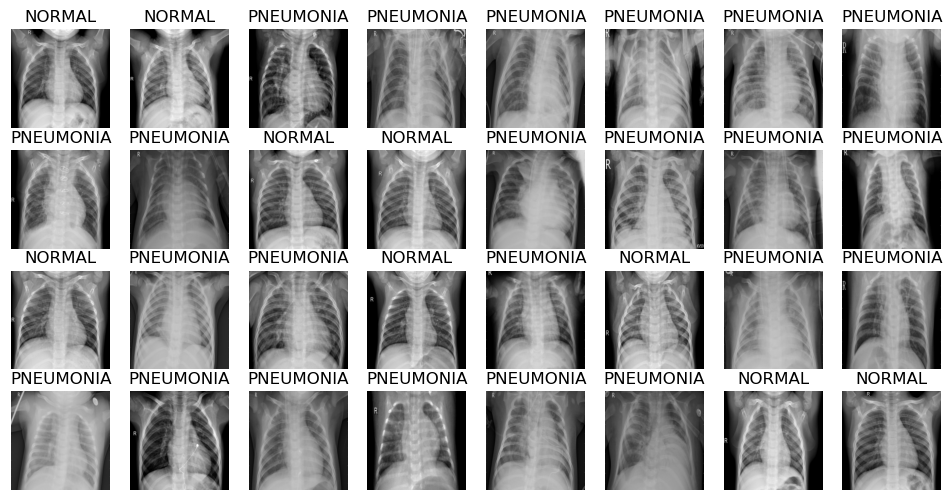

In [9]:
plt.figure(figsize=(12, 6))  
inverse = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])

for img,labels in train_loader: 
    break 
for i in range(len(img)//2):
    plt.subplot(4, 8, i + 1)
    image = inverse(img[i])
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.title(train_data.classes[labels[i]])
    plt.axis(False)

In [10]:
class PneumoniaClassifierCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                                    nn.Conv2d(3, 12, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(12),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2),
                                    nn.Conv2d(12, 32, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2),
                                    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.Flatten(),
                                    nn.Linear(200704,2))

        
    def forward(self,x):
        return self.layers(x)

In [11]:
model = PneumoniaClassifierCNN().to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
epochs = 10
for epoch in range(epochs):
    print(f'{epoch+1} of {epochs} epochs:')
    train_loss = 0
    for batch, (img, label) in enumerate(train_loader):
        
        img, label = img.to(device), label.to(device)
        
        preds = model(img) 
        loss = criterion(preds, label)
        train_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    print(f"Train loss: {train_loss:.5f}")

1 of 10 epochs:
Train loss: 1.36787
2 of 10 epochs:
Train loss: 0.47352
3 of 10 epochs:
Train loss: 0.37828
4 of 10 epochs:
Train loss: 0.30885
5 of 10 epochs:
Train loss: 0.09824
6 of 10 epochs:
Train loss: 0.24420
7 of 10 epochs:
Train loss: 0.05840
8 of 10 epochs:
Train loss: 0.11481
9 of 10 epochs:
Train loss: 0.02698
10 of 10 epochs:
Train loss: 0.03917


In [14]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred))
    return acc

def precision_fn(y_true, y_pred):
    true_positives = torch.logical_and(torch.eq(y_true, 1), torch.eq(y_pred, 1)).sum().item()
    predicted_positives = torch.eq(y_pred, 1).sum().item()
    precision = true_positives / predicted_positives
    return precision

def recall_fn(y_true, y_pred):
    true_positives = torch.logical_and(torch.eq(y_true, 1), torch.eq(y_pred, 1)).sum().item()
    label_positives = torch.eq(y_true, 1).sum().item()
    recall = true_positives / label_positives
    return recall

def f1_score_fn(y_true, y_pred):
    precision = precision_fn(y_true, y_pred)
    recall = recall_fn(y_true, y_pred)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score 

In [15]:
loss, accuracy, recall, precision, f1 = 0, 0, 0, 0, 0
model.eval()
with torch.inference_mode():
    for img, label in test_loader:
        
        img, label = img.to(device), label.to(device)
        preds = model(img)

        loss += criterion(preds, label)
        
        accuracy += accuracy_fn(label, preds.argmax(dim=1))
        recall += recall_fn(label, preds.argmax(dim=1))
        precision += precision_fn(label, preds.argmax(dim=1))
        f1 += f1_score_fn(label, preds.argmax(dim=1))

    loss /= len(test_loader)
    accuracy /= len(test_loader)
    recall /= len(test_loader)
    precision/= len(test_loader)
    f1 /= len(test_loader)

print(f"Loss: {loss:.5f},\n Accuracy: {accuracy:.2f},\n Recall: {recall:.2f},\n Precision: {precision:.2f},\n F1: {f1:.2f}\n")

Loss: 10.73763,
 Accuracy: 0.79,
 Recall: 0.99,
 Precision: 0.75,
 F1: 0.85



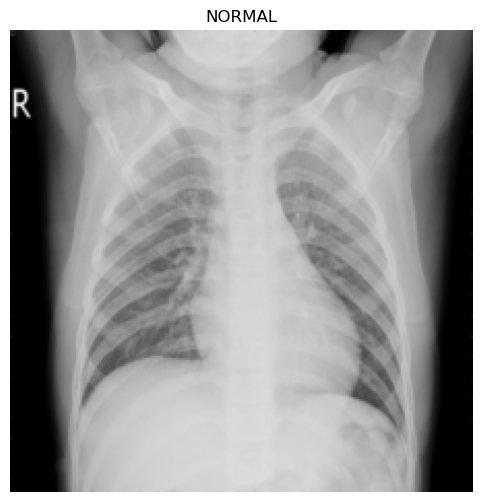

In [17]:
samples = datasets.ImageFolder(r"S:\Pneumonia classification project\Pneumonia classification project\chest_xray\samples", transform=transformation)
sample = samples[0][0].to(device)
sample = sample.unsqueeze(0)
with torch.inference_mode():
    pred = model(sample)
    output = pred.argmax(dim=1)

sample = sample.to("cpu")
sample = sample.squeeze(0)
plt.figure(figsize=(12, 6))
sample = inverse(sample)
plt.imshow(np.transpose(sample.numpy(), (1, 2, 0)))
plt.title(train_data.classes[labels[i]])
plt.axis(False);